# Question generation with seq2seq model
- Generate similar questions using Quora datset
- First, train seq2seq model with duplicate question pairs, and then predict another question seeing only one of questions
- reference: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
- dataset: http://qim.ec.quoracdn.net/quora_duplicate_questions.tsv

In [117]:
import numpy as np
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import Model
from keras.layers import *

### Import dataset
- Use Quora question pairs dataset
- If two questions are similar, 'is_duplicate' is marked 1, 0 if not

In [2]:
url = 'http://qim.ec.quoracdn.net/quora_duplicate_questions.tsv'

In [3]:
# import dataset using read_table() function in pandas
data = pd.read_table(url, sep ='\t')
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
# select question pairs that are "duplicate"
data = data[data['is_duplicate'] == 1]
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1


### Data processing
- Preprocess dataset to fit into seq2seq model

In [81]:
# number of samples and minimum count of words to include
num_samples = 10000
min_count = 5

In [93]:
q1 = list(data['question1'])[:num_samples]
q2 = list(data['question2'])[:num_samples]

In [77]:
# create a list to put in all words (tokens) in input and target dataset
input_words = []
target_words = []

In [78]:
for i in range(len(q1)):
    for token in q1[i].split():
        input_words.append(token)
    for token in q2[i].split():
        target_words.append(token)

In [79]:
# convert lists into sets to choose only unique tokens
unique_input_words = set(input_words)
unique_target_words = set(target_words)

Remove tokens that do not occur over 5 times (minimum count = 5)

In [82]:
%%time
to_delete = []
for token in unique_input_words:
    if input_words.count(token) < min_count:
        to_delete.append(token)

for token in to_delete:
    unique_input_words.remove(token)

Wall time: 32.4 s


In [83]:
%%time
to_delete = []
for token in unique_target_words:
    if target_words.count(token) < min_count:
        to_delete.append(token)

for token in to_delete:
    unique_target_words.remove(token)

Wall time: 32.6 s


To let model know beginning and end of sentence, inject symbols ('@' and '#') for target sentences
- '@': designates beginning of sentence
- '#': designates end of sentence

In [94]:
q1 = [q.split() for q in q1]
q2 = [('@ ' + q + ' #').split() for q in q2]

In [89]:
# also add symbols to unique token set
unique_target_words.update(['@', '#'])

Parsing sentences (questions)
- Split each sentence based on unique tokens

In [98]:
for i in range(len(q1)):
    q1[i] = [token for token in q1[i] if token in unique_input_words]
    q2[i] = [token for token in q2[i] if token in unique_target_words]

In [101]:
print(q1[0])
print(q2[0])
print(q1[5])
print(q2[5])

['I', 'am', 'a', 'Sun', 'moon', 'and', 'does', 'that', 'say', 'about', 'me?']
['@', "I'm", 'a', 'and', 'in', 'What', 'does', 'this', 'say', 'about', 'me?', '#']
['What', 'would', 'a', 'Trump', 'presidency', 'mean', 'for', 'current', 'international', 'students', 'on', 'an']
['@', 'How', 'will', 'a', 'Trump', 'presidency', 'affect', 'the', 'students', 'in', 'US', 'or', 'planning', 'to', 'study', 'in', 'US?', '#']


In [102]:
del input_words
del target_words

In [103]:
unique_input_words = sorted(list(unique_input_words))
unique_target_words = sorted(list(unique_target_words))

In [104]:
# number of tokens => dimensionality of one-hot encoding space of tokens
num_encoder_tokens = len(unique_input_words)
num_decoder_tokens = len(unique_target_words)

In [105]:
# maximum sequence length 
max_encoder_seq_len = max([len(q) for q in q1])
max_decoder_seq_len = max([len(q) for q in q2])

In [106]:
print('Total Number of samples: ', len(q1))
print('Number of unique input tokens (words): ', num_encoder_tokens)
print('Number of unique output tokens (words): ', num_decoder_tokens)
print('Max seq length for inputs: ', max_encoder_seq_len)
print('Max seq length for outputs: ', max_decoder_seq_len)

Total Number of samples:  10000
Number of unique input tokens (words):  1967
Number of unique output tokens (words):  1997
Max seq length for inputs:  35
Max seq length for outputs:  45


In [107]:
input_token_idx = dict([(token, i) for i, token in enumerate(unique_input_words)])
target_token_idx = dict([(token, i) for i, token in enumerate(unique_target_words)])

Create data for input & target
- Note that arrays are initially created with 'zeros' with maximum length
- Hence, if sequence is shorter than max length, it is automatically zero padded

In [108]:
encoder_input = np.zeros((len(q1), max_encoder_seq_len, num_encoder_tokens), dtype = 'float32')
decoder_input = np.zeros((len(q1), max_decoder_seq_len, num_decoder_tokens), dtype = 'float32')
decoder_target = np.zeros((len(q1), max_decoder_seq_len, num_decoder_tokens), dtype = 'float32')

Note that **decoder_target** is identical to **decoder_input** except that decoder_target is "offset by one timestep"
    - For instance, consider question **"How can I see all my Youtube comments?"**
    - Then, decoder_input data instance is **"How / can / I / see / all / my / Youtube / comments?"**, same as original question
    - But, corresponding decoder_target data instance is **"can / I / see / all / my / Youtube / comments?**
    - Like the table below, seq2seq model ssees **Input** and predicts **Target**
    
| Input |    |Target    |
|---------|-------|-----|
|How  | ========>|can  |
|can    | ========>      | I    |
|I    | ========>      | see    |
|see    | ========>      | all   |
|all    | ========>      | my    |
|my    | ========>      | Youtube    |
|Youtube    | ========>      | comments?    |
|comments?    | ========>      |     |

In [109]:
for i, (x, y) in enumerate(zip(q1, q2)):
    for t, token in enumerate(x):
        encoder_input[i, t, input_token_idx[token]] = 1.
    for t, token in enumerate(y):
        decoder_input[i, t, target_token_idx[token]] = 1.
        if t > 0:
            decoder_target[i, t-1, target_token_idx[token]] = 1.

### Create model
- Create seq2seq model
- seq2seq model here is similar to that of neural machine translation without attention
    - Consists of two LSTMs (encoder & decoder)
    
<br>
<img src="https://blog.keras.io/img/seq2seq/seq2seq-inference.png" style="width: 500px"/>


In [113]:
latent_dim = 300

In [114]:
encoder_inputs = Input(shape = (None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state = True)
_, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

In [115]:
decoder_inputs = Input(shape = (None, num_decoder_tokens))
lstm = LSTM(latent_dim, return_sequences = True, return_state = True)
decoder_outputs, _, _ = lstm(decoder_inputs, initial_state = encoder_states)
dense = Dense(num_decoder_tokens, activation = 'softmax')
decoder_outputs = dense(decoder_outputs)

In [116]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

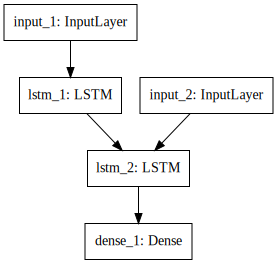

In [118]:
# visualizing the model
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [119]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')

In [141]:
%%time
model.fit([encoder_input, decoder_input], decoder_target, batch_size = 100, epochs = 100, verbose = 0)

Wall time: 3h 6min 3s


### Sampling and Testing
- Sample some questions and test their predictions
- Separate encoder & decoder model and decode sentences

In [121]:
encoder_model = Model(encoder_inputs, encoder_states)

In [122]:
decoder_state_input_h = Input(shape = (latent_dim, ))
decoder_state_input_c = Input(shape = (latent_dim, ))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

In [124]:
decoder_outputs, state_h, state_c = lstm(decoder_inputs, initial_state = decoder_state_inputs)
decoder_states = [state_h, state_c]

In [125]:
decoder_outputs = dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)

In [127]:
reverse_input_token_idx = dict((i, token) for token, i in input_token_idx.items())
reverse_target_token_idx = dict((i, token) for token, i in target_token_idx.items())

In [143]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_idx['@']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_token_idx[sampled_token_index]
        decoded_sentence += ' ' + sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '#' or
           len(decoded_sentence) > max_decoder_seq_len):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

### Results
- You could see that some synthetic questions make sense, even with our naive model

In [144]:
for idx in range(100):
    input_seq = encoder_input[idx: idx+1]
    decoded_sent = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', q1[idx])
    print('Decoded sentence:', decoded_sent)

-
Input sentence: ['I', 'am', 'a', 'Sun', 'moon', 'and', 'does', 'that', 'say', 'about', 'me?']
Decoded sentence:  I'm a and in What does this say about me? #
-
Input sentence: ['How', 'can', 'I', 'be', 'a', 'good']
Decoded sentence:  How do I become a film I live in #
-
Input sentence: ['How', 'do', 'I', 'read', 'and', 'find', 'my', 'YouTube']
Decoded sentence:  How can I change my #
-
Input sentence: ['What', 'can', 'make', 'easy', 'to', 'learn?']
Decoded sentence:  How can you make physics easy to learn? #
-
Input sentence: ['What', 'was', 'your', 'first', 'sexual', 'experience', 'like?']
Decoded sentence:  What was your first sexual experience? #
-
Input sentence: ['What', 'would', 'a', 'Trump', 'presidency', 'mean', 'for', 'current', 'international', 'students', 'on', 'an']
Decoded sentence:  How would a Trump presidency and get if Trump
-
Input sentence: ['What', 'does', 'mean?']
Decoded sentence:  What does #
-
Input sentence: ['Why', 'are', 'so', 'many', 'Quora', 'users', 'ques

-
Input sentence: ['Do', 'animals']
Decoded sentence:  Do animals #
-
Input sentence: ['How', 'do', 'you', 'get', 'deleted', 'Instagram']
Decoded sentence:  How can I recover a hacked Instagram? #
-
Input sentence: ['What', 'if', 'I', 'two', 'private', 'and', 'them', 'to', 'follow', 'each', 'other?']
Decoded sentence:  Does eating help with lose weight? Is it safe
-
Input sentence: ['What', 'was', 'the', 'significance', 'of', 'the', 'battle', 'of', 'Somme,', 'and', 'how', 'did', 'this', 'battle', 'compare', 'and', 'contrast', 'to', 'the', 'Battle', 'of']
Decoded sentence:  What was the significance of the battle of Somme,
-
Input sentence: ['Is', 'it', 'possible', 'to', 'pursue', 'many', 'different', 'things', 'in', 'life?']
Decoded sentence:  How do I to chose between different things to
-
Input sentence: ['Did', 'Ben', 'more', 'than', 'Christian', 'as']
Decoded sentence:  Why do you think you were for a racist? #
-
Input sentence: ['Which', 'business', 'is', 'good', 'start', 'up', 'i